<div style="text-align: center;">
  <h1>TA136 - Taller de Procesamiento de Señales</h1>
  <h2>Trabajo Práctico 12: PyMC </h2>
</div>

---
---

<div style="text-align: center;">
  <h3> Introducción
</div>

&ensp; En el presente trabajo práctico se busca estimar la proporción de estudiantes que hacen trampa en un examen, utilizando un mecanismo de privacidad aleatorio basado en lanzamientos de monedas. Este método garantiza la privacidad de las respuestas al introducir incertidumbre controlada en el proceso de recolección de datos.

&ensp; En primer lugar, se realizan cálculos teóricos correspondientes al problema planteado. Estos, son de utilidad para pensar lo posteriormente implementado a nivel código. Además, se genera el *dataset* del esquema planteado.

&ensp; Luego, se desarrolla el modelo bayesiano con la librería $\texttt{PyMC}$, en el cual se modelan explícitamente las variables que representan si un estudiante hizo trampa y las observables correspondientes a las respuestas de los alumnos. Cabe destacar que se asume una distribución a priori uniforme para la probabilidad $p$ de hacer trampa.

&ensp; Por último, se realiza el muestreo de la distribución a posteriori utilizando el método *Markov Chain Monte Carlo* con $3$ cadenas independientes, eligiendo los parámetros adecuados para garantizar una buena convergencia de los resultados. En función de esto, se analiza la densidad posterior del parámetro $p$ y se calculan probabilidades predictivas tanto de que un estudiante afirme haber hecho trampa como de que efectivamente lo haya hecho, evaluando así el comportamiento del modelo.


---
---

<div style="text-align: center;">
  <h3> Desarrollo
</div>

**Se quiere inferir la probabilidad $p$ de que un estudiante haga trampa en un examen. Se propone el siguiente algoritmo de privacidad para entrevistar a los estudiantes luego del examen y preguntarle si hicieron trampa: Cada estudiante lanza una moneda (oculta al entrevistador). El estudiante responderá sinceramente si la moneda sale cara. Si sale ceca, el estudiante (en secreto) lanza una $2^{\text{da}}$ moneda y responde “Sí, hice trampa” si el lanzamiento de la moneda sale cara, y “No, no hice trampa”, si sale ceca. De esta manera, el entrevistador no sabe si el resultado fue una declaración de culpabilidad, o una cara en un segundo lanzamiento de moneda y así se preserva la privacidad de los estudiantes. Si de $100$ estudiantes entrevistados $30$ dicen haber hecho trampa, y asumimos una distribución a priori uniforme para $p$:**

---

#### (A). *Análisis teórico:*

&ensp; Previo a calcular las probabilidades, se determina el modelo probabilístico a utilizar a fin de resolver el presente trabajo. Para esto, se definen las siguientes variables aleatorias, que modelan lo enunciado.

- $T_i \sim \text{Ber}(p)$, indica si el estudiante $i$ hizo trampa.

\begin{align*}
    \begin{cases}
        T_i = 1 \Longrightarrow \text{hizo trampa} \\
        T_i = 0 \Longrightarrow \text{no hizo trampa}
    \end{cases}
\end{align*}

- $M_{i, ~ 1} \sim \text{Ber}\left( \frac{1}{2} \right)$, denota el resultado de la primer moneda que se tira.

\begin{align*}
    \begin{cases}
        M_{i, ~ 1} = 1 \Longrightarrow \text{cara}\\
        M_{i, ~ 1} = 0 \Longrightarrow \text{ceca}
    \end{cases}
\end{align*}

- $M_{i, ~ 2} \sim \text{Ber}\left( \frac{1}{2} \right)$, modela la segunda moneda que se lanza, en caso de que salga ceca. Sigue los mismos lineamientos que la variable anterior.

- $R_i \in \left\{0, ~ 1 \right\}$, expresa la respuesta del estudiante, es decir, si hizo o no trampa. Depende claramente de $T_i$, $M_{i, ~ 1}$ y $M_{i, ~ 2}$

\begin{align*}
    \begin{cases}
        R_i = T_i  \quad &\text{si} ~~ M_{i, ~ 1} = 1 \\
        R_i = M_{i, ~ 2}  \quad &\text{si} ~~ M_{i, ~ 1} = 0
    \end{cases}
\end{align*}

&ensp; Así, se define el árbol de probabilidades que se visualiza a continuación.

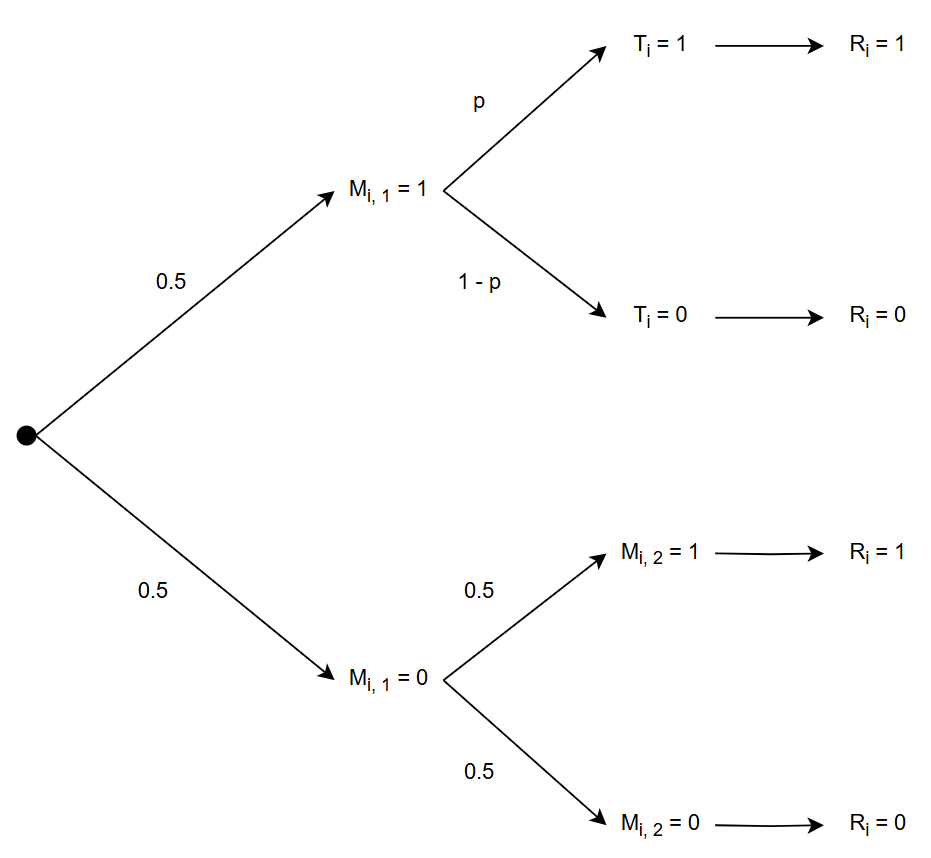

- **Si asumimos que el estudiante hizo trampa, calcular la probabilidad de que un estudiante diga que hizo trampa.**

&ensp; A fin de resolver esto, se analiza el árbol de probabilidades considerando que en este caso $p = 1$, puesto que el alumno hizo trampa. Así, teniendo en cuenta la suma de probabilidades de eventos disjuntos y que la probabilidad de la intersección de variables independientes es la multiplicación de las mismas, se deduce el resultado correspondiente.

$$ P(R_i = 1 ~ | ~ T_i = 1) = P(M_{i, ~ 1} = 1) + P(M_{i, ~ 1} = 0, ~ M_{i, ~ 2} = 1) =  \frac{1}{2} +  \frac{1}{2} \cdot \frac{1}{2} = \frac{3}{4} $$

\\
- **Si asumimos que el estudiante no hizo trampa, calcular la probabilidad de que un estudiante diga que hizo trampa.**

&ensp; Ahora, se tiene que $p = 0$, ya que, se asume que el alumno no hizo trampa. Entonces, visualizando el árbol y procediendo análogamente a lo realizado anteriormente, se obtiene:

$$P(R_i = 1 ~ | ~ T_i = 0) = P(M_{i, ~ 1} = 0, ~ M_{i, ~ 2} = 1) = \frac{1}{2} \cdot \frac{1}{2} = \frac{1}{4}$$

\\
- **Si asumimos un $p$ conocido, calcular la probabilidad de que un estudiante diga que hizo trampa en función de $p$.**

&ensp; De esta misma forma, en base al árbol de probabilidades, se plantea lo siguiente:

$$P(R_i = 1 ~ | ~ p) = P(M_{i, ~ 1} = 1, ~ T_i = 1) + P(M_{i, ~ 1} = 0, ~ M_{i, ~ 2} = 1) = \frac{1}{2} \cdot p + \frac{1}{2} \cdot \frac{1}{2} = \frac{1}{2} \cdot p + \frac{1}{4} $$

Una vez obtenido este resultado, se puede definir la variable correspondiente a la respuesta del estudiante como:

$$ R_i \sim \text{Ber}\left( \phi(p) \right) \Longrightarrow
\begin{cases}
        R_i = 1  \Longrightarrow \text{responde que hizo trampa} \\
        R_i = 0  \Longrightarrow \text{responde que no hizo trampa}
\end{cases}$$

donde $\phi(p) = P(R_i = 1 ~ | ~ p) = \frac{1}{2} \cdot p + \frac{1}{4}$ es la probabilidad de éxito.

\\
- **Hallar la densidad a posteriori de $p$. Puede expresar el resultado utilizando constantes multiplicativas sin definir.**

&ensp; La densidad a posteriori de $p$ se calcula en base a la siguiente expresión, siendo $\mathcal{D} = \left\{ r_1, ~ \dots ~, ~r_n \right\}$ las realizaciones de las respuestas de los alumnos.

$$ P(p ~ | ~ \mathcal{D}) \propto P(p) \cdot P( \mathcal{D} ~ | ~ p)$$

Por consigna, se tiene que la distribución a priori de $p$ es uniforme. Además, considerando que es una probabilidad, su soporte es $\left[0, ~ 1 \right]$. Entonces, se concluye que:

$$ P(p) = 1 \quad \text{para} ~ p \in \left[0, ~ 1 \right]$$

&ensp; Así, se obtiene que la densidad a posteriori depende únicamente de la verosimilitud.

$$ P(p ~ | ~ \mathcal{D}) \propto P( \mathcal{D} ~ | ~ p)$$

Según lo visto en el apartado anterior, se entiende que las respuestas de los estudiantes son independientes y están condicionalmente distribuidas como una Bernoulli de parámetro $\phi(p) = \frac{1}{2} \cdot p + \frac{1}{4}$. Entonces, se puede escribir la verosimilitud como la multiplicatoria de las densidades:

$$P( \mathcal{D} ~ | ~ p) = \prod_{i=0}^n \left( \phi(p) \right)^{r_i} \cdot \left( 1 - \phi(p) \right)^{1 - r_i} =  \left( \frac{1}{2} \cdot p + \frac{1}{4} \right)^{k} \cdot \left( \frac{3}{4} - \frac{1}{2} \cdot p\right)^{n - k}$$

&ensp; De esta manera, se deduce la expresión de la distribución a posteriori de $p$, tal que:

$$ P(p ~ | ~ \mathcal{D}) \propto \left( \frac{1}{2} \cdot p + \frac{1}{4} \right)^{k} \cdot \left( \frac{3}{4} - \frac{1}{2} \cdot p\right)^{n - k}$$

Siendo $K$ la cantidad total de respuestas positivas y $n$ el total de estudiantes.

\\
- **Hallar una expresión para la probabilidad (predictiva) de que un nuevo estudiante diga haber hecho trampa. Expresar el resultado en función de la esperanza a posteriori.**

&ensp; Con el fin de realizar este inciso, se analiza la predictiva del modelo bayesiano teniendo en cuenta que el nuevo estudiante diga haber hecho trampa.

$$ P(R_{\text{test}} = 1 ~ | ~ \mathcal{D}) = \int_\Theta P(R_{\text{test}} = 1 ~ | ~ \theta) ~ P (\theta ~ | ~ \mathcal{D}) ~ d\theta = E \left[ P(R_{\text{test}} = 1 ~ | ~ p) ~ | ~ \mathcal{D} \right]$$

&ensp; En base a esto y considerando que $\phi(p) = P(R_{\text{test}} = 1 ~ | ~ p) = \frac{1}{2} \cdot p + \frac{1}{4}$, se puede avanzar algebraicamente sobre la expresión anterior.

\begin{align*}
    P(R_{\text{test}} = 1 ~ | ~ \mathcal{D}) &= E \left[ P(R_{\text{test}} = 1 ~ | ~ p) ~ | ~ \mathcal{D} \right] = E \left[ \phi(p) ~ | ~ \mathcal{D} \right] = E \left[ \frac{1}{2} \cdot p + \frac{1}{4} ~ \big| ~ \mathcal{D} \right] = \frac{1}{2} \cdot  E \left[ p ~ | ~ \mathcal{D} \right] + \frac{1}{4}
\end{align*}

\\
- **Hallar una expresión para la probabilidad (predictiva) de que un nuevo estudiante haga trampa, expresando el resultado en función de la esperanza a posteriori.**

&ensp; Nuevamente, se comienza a partir de la predictiva del modelo bayesiano.

$$ P(T_{\text{test}} = 1 ~ | ~ \mathcal{D}) = \int_\Theta P(T_{\text{test}} = 1 ~ | ~ \theta) ~ P (\theta ~ | ~ \mathcal{D}) ~ d\theta = E \left[ P(T_{\text{test}} = 1 ~ | ~ p) ~ | ~ \mathcal{D} \right]$$

&ensp; En este caso, se debe obtener la probabilidad $P(T_{\text{test}} = 1 ~ | ~ p)$. Para ello, como se sabe que la variable se distribuye como una Bernoulli, se tiene que la probabilidad es:

$$ T_i \sim \text{Ber}(p) \Longrightarrow P(T_{\text{test}} = 1 ~ | ~ p) = p$$

&ensp; Así, volviendo a la predictiva, se concluye que:

\begin{align*}
P(T_{\text{test}} = 1 ~ | ~ \mathcal{D}) = E \left[ P(T_{\text{test}} = 1 ~ | ~ p) ~ | ~ \mathcal{D} \right] = E \left[ p ~ | ~ \mathcal{D} \right]
\end{align*}


---

#### (B). *Generación de datos:*

**Crear el conjunto de entrenamiento descripto en el enunciado del problema. Reordenarlo al azar.**

&ensp; A partir de la descripción teórica del apartado anterior, se construye el conjunto de entrenamiento. Para ello, se consideran los $100$ alumnos en total, de los cuales $30$ declaran haber hecho trampa. Con esta información, se genera un arreglo de alumnos que luego se reordena aleatoriamente utilizando la función $\text{random.shuffle}$, que se puede visualizar en el *dataframe* impreso.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc as pm
import arviz as az

In [ ]:
n = 100
k = 30

R_test = np.array([1] * k + [0] * (n - k))
np.random.shuffle(R_test)

display(pd.DataFrame(R_test, columns=['R_test']))

,R_test
0,0
1,0
2,1
3,0
4,0
...,...
95,1
96,1
97,1
98,1


---

#### (C). *PyMC:*

- **Construir el modelo bayesiano antes descripto en *PyMC*. El mismo debe contener la variable observable y la variable que representa si efectivamente el estudiante hizo trampa y respetar la causalidad del problema.**

&ensp; En función de lo realizado en el apartado teórico para el modelo probabilístico y considerando lo visto en las clases teóricas de la materia, se construye el modelo bayesiano según la librería $\texttt{PyMC}$. Así, se desarrolló el siguiente código, teniendo en cuenta la distribución de cada una de las variables que componen al modelo.




In [ ]:
with pm.Model() as model:
    p = pm.Uniform("p", 0, 1)
    T = pm.Bernoulli("T", p=p, shape=n)

    phi = (1 / 2) * T + (1 / 4)
    R = pm.Bernoulli("R", p=phi, observed=R_test)

- **Utilizando $\texttt{model\_to\_graphviz}$ (*PyMC*), graficar la red bayesiana.**

&ensp; Una vez construido el modelo, se lo representa mediante un grafo utilizando la función $\texttt{pm.model_to_graphviz}$. En esta representación, se observa explícitamente la estructura causal del modelo: la variable $T_i$, que indica si el estudiante hizo trampa, depende del parámetro $p$, modelado como una distribución uniforme. A su vez, la variable observable $R_i$, que representa la respuesta del estudiante, depende directamente de $T_i$ de acuerdo al mecanismo de privacidad planteado. La placa indica que este proceso se repite para $n = 100$ estudiantes, generando así $100$ $T_i$ y $R_i$.

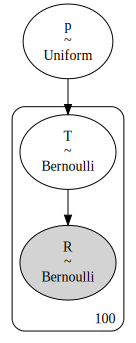

In [ ]:
pm.model_to_graphviz(model)

- **Muestrear $3$ cadenas del experimento. Elegir los parámetros draws y tune de manera que *PyMC* no genere advertencias (*warnings*) y de alcanzar un $ ~ \text{ESS (bulk)} > 300$ y un $\hat{R} \leq 1.01$ para $p$.**

&ensp; A partir del modelo desarrollado en los incisos anteriores, se procede a realizar el muestreo de $3$ cadenas del experimento utilizando la función $\texttt{pm.sample}$. Para esto, se configuraron los parámetros `tune=4000` y `draws=5000`, lo que implica que se descartan las primeras $4000$ muestras de cada cadena para favorecer la convergencia del muestreador, mientras que, las $5000$ muestras restantes corresponden a la fase útil del muestreo.

&ensp; Esta configuración permitió evitar advertencias y alcanzar valores satisfactorios, que rondan el orden de los $ \text{ESS (bulk)} \approx \left[ 600, ~ 700 \right] $ y $\hat{R} \approx 1.003$ para el parámetro $p$.

In [ ]:
n_cadenas = 3

with model:
    trace = pm.sample(tune=4000, draws=5000, chains=n_cadenas, cores=n_cadenas)

display(az.summary(trace, var_names=["p"], round_to=3))

Output()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,0.129,0.076,0.0,0.258,0.003,0.001,621.015,880.144,1.007


- **Utilizando $\texttt{plot\_posterior}$ (*PyMC*), graficar la densidad a posteriori.**

&ensp; A partir del muestreo de la distribución a posteriori del parámetro $p$, se utilizó la función $\texttt{plot\_posterior}$ para visualizar su densidad. En la imagen se observa una distribución concentrada principalmente entre valores bajos de $p$, con una media posterior estimada en aproximadamente $0.13$.

&ensp; Además, se muestra el intervalo de densidad más alta (*HDI*) del $94\%$. Este, representa la región más creíble de valores para $p$, dado el modelo y los datos observados. La forma asimétrica de la densidad posterior refleja que, aunque es posible que $p$ sea muy cercano a cero, también existe una probabilidad baja de que tome valores moderadamente mayores, aunque con menor densidad.

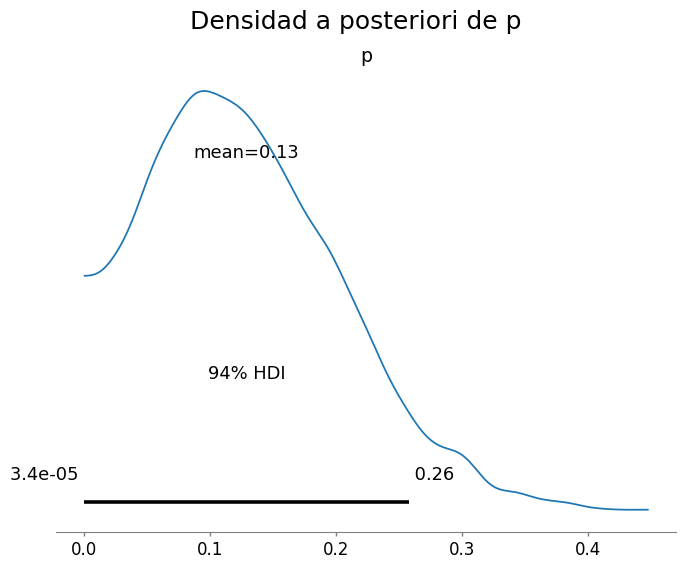

In [ ]:
pm.plot_posterior(trace, var_names=["p"], figsize=(8, 6), textsize=12)
plt.suptitle("Densidad a posteriori de p", fontsize=18)
plt.show()

- **Muestrear la distribución a posteriori para aproximar la probabilidad predictiva de que un estudiante diga haber hecho trampa por cadena.**

&ensp; De acuerdo con lo desarrollado en el apartado teórico, es posible calcular la probabilidad predictiva de que un estudiante afirme haber hecho trampa, a partir de la estimación de la distribución a posteriori del parámetro $p$ obtenida mediante el método *Markov Chain Monte Carlo*.

&ensp; Los valores obtenidos para esta probabilidad son coherentee con lo esperado teóricamente, ya que, según el enunciado del experimento, se observa que aproximadamente $30$ de cada $100$ estudiantes declara haber hecho trampa, en línea con la proporción observada en lo estimado.

In [ ]:
from IPython.display import display, Latex

In [ ]:
p_samples = trace.posterior["p"].values
predict_r = (1 / 2) * np.mean(p_samples, axis=1) + 1 / 4

for i in range(n_cadenas):
    display(Latex(fr'$P(R_{{\text{{test}}}} = 1 ~ | ~ \mathcal{{D}}) = E \left[ P(R_{{\text{{test}}}} = 1 ~ | ~ p) ~ | ~ \mathcal{{D}} \right] = \frac{{1}}{{2}} \cdot  E \left[ p ~ | ~ \mathcal{{D}} \right] + \frac{{1}}{{4}} \approx {predict_r[i]:.3f}$'))


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

- **Muestrear la distribución a posteriori para aproximar la probabilidad predictiva de que un estudiante haga trampa por cadena.**

&ensp; Análogamente a lo realizado en el punto anterior, se tiene en el apartado teórico el resultado obtenido para la predictiva de que un estudiante haya hecho trampa en la evaluación.

In [ ]:
predict_t = np.mean(p_samples, axis=1)

for i in range(n_cadenas):
    display(Latex(fr'$P(T_{{\text{{test}}}} = 1 ~ | ~ \mathcal{{D}}) = E \left[ P(T_{{\text{{test}}}} = 1 ~ | ~ p) ~ | ~ \mathcal{{D}} \right] = E \left[ p ~ | ~ \mathcal{{D}} \right] \approx {predict_t[i]:.3f}$'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

---
---

<div style="text-align: center;">
  <h3> Conclusiones
</div>

&ensp; La implementación del modelo bayesiano permitió estimar la distribución a posteriori de la proporción $p$ de estudiantes que hacen trampa, a partir de observaciones distorsionadas por el método dado por consignas. El modelo fue implementado correctamente utilizando $\texttt{PyMC}$, según lo visto en las clases del curso.

&ensp; En el apartado teórico se desarrollaron las expresiones necesarias para calcular tanto la probabilidad de que un estudiante diga haber hecho trampa como la densidad a posteriori del parámetro $p$. Luego, los resultados obtenidos mediante el *MCMC* coincidieron con las predicciones teóricas, lo que evidencia la validez y correspondencia entre métodos.

&ensp; Además, el *dataset* fue generado de acuerdo al procedimiento planteado, obteniendo así realizaciones de la variable observable de la experiencia. Esto permitió modelarlo y validar que los valores simulados respondieran a la estructura probabilística analizada.

&ensp; También, a partir del muestreo de la distribución posterior, se calcularon las probabilidades predictivas de interés. En particular, se verificó que la probabilidad de que un nuevo estudiante diga haber hecho trampa se encuentra alineada con la proporción observada en los datos, y coherente con el mecanismo de privacidad empleado.

&ensp; En conclusión, el trabajo permitió modelar de forma efectiva el problema planteado, integrando los conceptos de inferencia bayesiana y análisis predictivo mediante herramientas como $\texttt{Python}$ y la librería $\texttt{PyMC}$.

